<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-0.0.1">Notebook Description</a></span></li><li><span><a href="#Import-SBML-model" data-toc-modified-id="Import-SBML-model-0.0.2">Import SBML model</a></span></li><li><span><a href="#Construct-SymPy-Matrix" data-toc-modified-id="Construct-SymPy-Matrix-0.0.3">Construct SymPy Matrix</a></span></li><li><span><a href="#Construct-Nullspace-Matrix" data-toc-modified-id="Construct-Nullspace-Matrix-0.0.4">Construct Nullspace Matrix</a></span></li><li><span><a href="#Performance-Comparison" data-toc-modified-id="Performance-Comparison-0.0.5">Performance Comparison</a></span></li></ul></li></ul></li></ul></div>

### Notebook Description

This notebook walks through an approach to generating a symbolic matrices from a custom `SciPyModel` class in Python for use in sampling and sensitivity analysis. This notebook will be the basis for implementing an extension of the functionality provided by the SBML2SciPy toolbox.

### Import SBML model
Execute functions to convert SBML model to custom class.

In [1]:
from utils import SBML2SciPy
SciPyModel = SBML2SciPy.importSBMLFile(SBML2SciPy.createSciPyModel())

### Construct SymPy Matrix

Using the SciPyModel object, construct a symbolic version of the ODE matrix.

In [2]:
SciPyModel = SBML2SciPy.writeODEFunction( SciPyModel )
open('temp.py', 'w+').write(SciPyModel.ToolboxFunctions.DerivativeFunction)

Using the SymPy module, create two symbolic vectors for species and parameters.

In [95]:
import sympy
y = sympy.symarray('y', len(SciPyModel.Species.Names))
p = sympy.symarray('p', len(SciPyModel.Parameters.Kinetic.Names))

TypeError: symarray() got an unexpected keyword argument 'positive'

Construct symbolic matrices for reaction vector and stoichiometric matrix.

In [4]:
from temp import rxn_fun
R = sympy.Matrix(rxn_fun(y,0,p))
S = sympy.Matrix(SciPyModel.Reactions.Stoichiometry)

Assemble symbolic derivative matrix. Must be assembled carefully to avoid bad assembly by `reshape`.

In [5]:
DerivativeMatrix = sympy.Matrix(
    [S[:,i]*R[i] for i in range(len(R))]).reshape(S.shape[1],S.shape[0]).transpose()
display(DerivativeMatrix)

Matrix([
[-1.0*p_0*y_0, -1.0*p_1*y_0,  1.0*p_2*y_2,            0,            0,            0,            0, 1.0*p_7*y_0,           0],
[ 1.0*p_0*y_0,            0,            0,  1.0*p_3*y_3,            0,            0, -1.0*p_6*y_1,           0,           0],
[           0,  1.0*p_1*y_0, -1.0*p_2*y_2,            0, -1.0*p_4*y_2,            0,            0,           0, 1.0*p_8*y_2],
[           0,            0,            0, -1.0*p_3*y_3,  1.0*p_4*y_2, -1.0*p_5*y_3,            0,           0,           0],
[           0,            0,            0,            0,            0,            0,            0,           0,           0],
[           0,            0,            0,            0,            0,            0,            0,           0,           0]])

### Construct Nullspace Matrix
Using the symbolic derivative matrix, we can now solve for the nullspace. Mathematically the operation we will be performing is a follows.

Let $X \in \mathbb{R}^n$ be a vector of state variables, $K \in \mathbb{R}^m$ be a vector of rate constants, $E \in \mathbb{p}$ be a vector of shape parameters.  Then let $A: \mathbb{R}^{n\times m} \mapsto \mathbb{R}^{n}$ be the matrix containing the $m$ ordinary differential equations. We can find the null space by solving the following linear equation.

\begin{equation*}
A_{(X,E)}\cdot K ~=~ \mathbf{0}
\end{equation*}

For efficiency in sampling, we apply the steady-state condition to the matrix $A$. The steady-state condition is given by the state variable and shape parameter vectors. Hence, we are looking to create a function which returns the nullspace with respect to a given steady-state condition in order to find corresponding kinetic parameters.

In [6]:
M = sympy.Matrix(
    sympy.lambdify((p),DerivativeMatrix,'sympy')(*sympy.ones(len(p),1)))
display(M)

Matrix([
[-1.0*y_0, -1.0*y_0,  1.0*y_2,        0,        0,        0,        0, 1.0*y_0,       0],
[ 1.0*y_0,        0,        0,  1.0*y_3,        0,        0, -1.0*y_1,       0,       0],
[       0,  1.0*y_0, -1.0*y_2,        0, -1.0*y_2,        0,        0,       0, 1.0*y_2],
[       0,        0,        0, -1.0*y_3,  1.0*y_2, -1.0*y_3,        0,       0,       0],
[       0,        0,        0,        0,        0,        0,        0,       0,       0],
[       0,        0,        0,        0,        0,        0,        0,       0,       0]])

In [66]:
NullSpace = M.nullspace()
print 'This nullspace is spanned by %s vectors' % len(NullSpace)
print 'Hence we only have %s free kinetic parameters' % (SciPyModel.Parameters.Kinetic.Quantity - len(
    NullSpace))

This nullspace is spanned by 5 vectors
Hence we only have 4 free kinetic parameters


We can see the set of linear equations spanning the nullspace by doting this basis with the kinetic parameters. For each we will set the expression equal to zero.

In [100]:
NullEqns = []
for i in range(len(NullSpace)):
    NullEqns.append( sympy.Eq(NullSpace[i].dot(p), 0) )

Then we can solve the system of equations using `solve` function in `SymPy`. The flag `manual=True` provides the best solution time for this particular set of problems.

In [101]:
display(NullEqns)
NullSample = sympy.solve(NullEqns, manual=True)
display(NullSample)

[1.0*p_1*y_2/y_0 + p_2 == 0,
 -1.0*p_0*y_2/y_0 + 1.0*p_1*y_2/y_0 + 1.0*p_3*y_2/y_3 + p_4 == 0,
 1.0*p_3*y_1/y_3 - 1.0*p_5*y_1/y_3 + p_6 == 0,
 1.0*p_0 - 1.0*p_3*y_0/y_3 + 1.0*p_5*y_0/y_3 + p_7 == 0,
 1.0*p_0*y_2/y_0 - 1.0*p_1*y_2/y_0 - 1.0*p_3*y_2/y_3 + 1.0*p_5*y_2/y_3 + p_8 == 0]

[{p_0: -p_6*y_0/y_1 - p_7,
  p_1: -y_0*(p_7*y_2/y_0 - p_8)/y_2,
  p_2: p_7*y_2/y_0 - p_8,
  p_3: p_5 - p_6*y_3/y_1,
  p_4: -p_5*y_2/y_3 - p_8}]

Replace parameter declarations with respective function ahead of lamdification.

In [102]:
pNew = []
for key in p:
    try:
        pNew.append( NullSample[0][key] )
    except KeyError:
        pNew.append( key )
        
display(pNew)

[-p_6*y_0/y_1 - p_7,
 -y_0*(p_7*y_2/y_0 - p_8)/y_2,
 p_7*y_2/y_0 - p_8,
 p_5 - p_6*y_3/y_1,
 -p_5*y_2/y_3 - p_8,
 p_5,
 p_6,
 p_7,
 p_8]

In [ ]:
pNewEqns = []
for eqn in pNew:
    pNewEqns.append( )

Create anonymous function which returns kinetic parameter vector inside nullspace based on steady-state condition and free-kinetic parameters.

In [88]:
NullSpaceFunction = sympy.lambdify(((p),(y)), pNew, 'numpy', dummify=False)

Then using `NullSpaceFunction` we can now limit our parameter sampling to only those which satisfy the steady state condition.

### Performance Comparison

Now with a reliable method to obtain the nullspace, we can see the benefit of its use on the simulation of the model. First we can simulate the model using the given initial condition and parameterization.

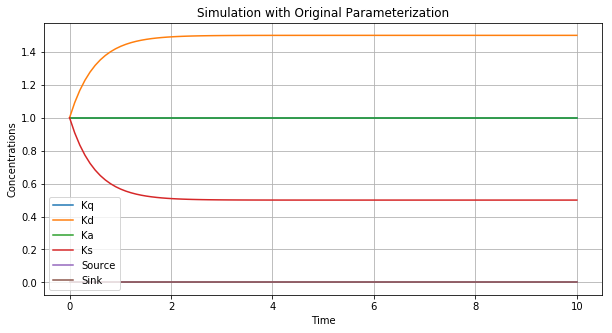

In [9]:
from temp import ode_fun
from scipy.integrate import odeint
import numpy
from matplotlib import pyplot as plt


%matplotlib inline

TVec = numpy.linspace(0,10,100)

YBase = odeint(ode_fun, SciPyModel.Species.Value, TVec, 
               args=(SciPyModel.Parameters.Kinetic.Value,))

plt.close()
plt.figure(figsize=(10,5))

LineObjs = plt.plot(TVec,YBase)
plt.grid()

plt.title('Simulation with Original Parameterization')
plt.xlabel('Time')
plt.ylabel('Concentrations')

plt.legend(LineObjs, SciPyModel.Species.Names)

plt.show()

Now we can exploit the nullspace to preserve the steady state condition.

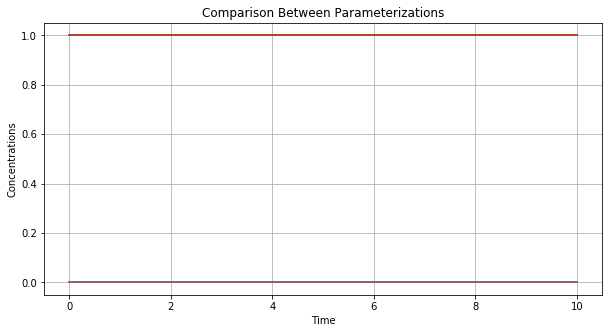

In [107]:
import numpy

fixedsample = [0,0,0,0,0,1,0,0,0]

Sample = NullSpaceFunction( (fixedsample),(SciPyModel.Species.Value) )

YAlt = odeint(ode_fun, SciPyModel.Species.Value, TVec, args=(Sample,))

plt.close()
plt.figure(figsize=(10,5))

MoreObjs = plt.plot(TVec,YAlt)
plt.grid()

plt.title('Comparison Between Parameterizations')
plt.xlabel('Time')
plt.ylabel('Concentrations')

plt.show()

In [106]:
print Sample

[0.0, -0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0]
